**[GitHub url]**
https://github.com/youngseo0526/Deep-Learning

**Dataset** https://www.kaggle.com/mbkinaci/fruit-images-for-object-detection

## 1. Settings
### 1) Important required libraries

In [32]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
import utils

### 2) Hyperparameter

In [33]:
batch_size = 16   # 64  # 1
learning_rate = 0.0001
epoch = 20 

n_node = 1024 # customized last layer 의 노드 수. 64, 128, 256, 512, 1024
dropratio = 0.5 # 얼마나 드랍시킬 지 inverse keepratio

imgsize = 256

## 2. Data Loader
### 트레이닝 데이터

In [34]:
img_dir = '/content/gdrive/My Drive/Colab Notebooks/[실습 05] Transfer Learning/fruits/train'

train_data = dset.ImageFolder(img_dir, transforms.Compose([
    transforms.CenterCrop(imgsize*2), 
    transforms.RandomCrop(imgsize),
    transforms.RandomHorizontalFlip(),
    
    transforms.Resize(imgsize),
    transforms.ToTensor()
]))
print(train_data.__len__())
train_batch = data.DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers=2)

82


### 고정된 데이터 셋

In [35]:
# 2. Dev data
img_dir = '/content/gdrive/My Drive/Colab Notebooks/[실습 05] Transfer Learning/fruits/val'
dev_data = dset.ImageFolder(img_dir, transforms.Compose([
    #transfoms.Scale(256),
    #transforms.RandomSizedCrop(244),                                                     

    transforms.CenterCrop(size=imgsize),
    transforms.Resize(imgsize),
    transforms.ToTensor()
]))
print(dev_data.__len__())
dev_batch = data.DataLoader(dev_data, batch_size = batch_size, shuffle = True, num_workers=2)

31


In [37]:
##test
img_dir = '/content/gdrive/My Drive/Colab Notebooks/[실습 05] Transfer Learning/fruits/test'
test_data = dset.ImageFolder(img_dir, transforms.Compose([
      #transfoms.Scale(256),
    #transforms.RandomSizedCrop(244), 

    transforms.CenterCrop(size=imgsize),
    transforms.Resize(imgsize),
    transforms.ToTensor()
]))
print(test_data.__len__())
test_batch = data.DataLoader(test_data, batch_size = batch_size, shuffle = True, num_workers=2)

38


In [38]:
nclass = len(train_data.classes)

print("# of classes : %d" %nclass)
print(train_data.classes)
print(train_data.class_to_idx)
print(train_data.__len__())

print("Training: %d, Dev: %d, Test: %d" 
      %(train_data.__len__(), dev_data.__len__(), test_data.__len__()))

# of classes : 2
['apples', 'bananas']
{'apples': 0, 'bananas': 1}
82
Training: 82, Dev: 31, Test: 38


In [39]:
print(train_data.classes)
print(dev_data.classes)
print(test_data.classes)

['apples', 'bananas']
['apples', 'bananas']
['apples', 'bananas']


## 3. Model
### 1) Pretrained VGG Model

In [42]:
vgg = models.vgg19(pretrained = True)

for name, module in vgg.named_children():
    print(name)
    
print(list(vgg.children())[0])
print(list(vgg.children())[-1])

#cnt = 0
#for i in model.children():
#  print ("yhk[%d]" %cnt),
#  print(i)
#  cnt = cnt + 1

features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(

In [43]:
print(list(vgg.children())[0][0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


### 2) Customized Fully Model

In [48]:
base_dim = 64
fsize = imgsize/32

class MyVGG(nn.Module):
    def __init__(self):
        super(MyVGG, self).__init__()
        # [0]: features(conv), [1]: classifier(fc)
        self.layer0 = nn.Sequential(*list(vgg.children())[0])
        
        self.layer1 = nn.Sequential(  
            nn.Linear(8 * base_dim * int(fsize) * int(fsize) , n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio), # 0.3만큼 드랍 하자.
            
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout(dropratio),
            
            nn.Linear(n_node, nclass),
        )
        
        # weight initalization
        for m in self.layer1.modules() :
            # print(m)
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight.data) # RELU일 때
                m.bias.data.fill_(0)
            if isinstance(m, nn.Linear):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)    
    def forward(self, x):
        # layer 0의 사이즈를 무식하게 프린트하여 알아낼 수 있음(batchsize, x,x,x)
        # print(x.size())
        out = self.layer0(x)
        out = out.view(out.size(0),-1)
        out = self.layer1(out)
        return out

### 3) Model on GPU

In [49]:
model = MyVGG().cuda()

for params in model.layer0.parameters():
    params.required_grad = False

for params in model.layer1.parameters():
    params.required_grad = True

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [50]:
for name in model.children():
    print(name)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## 4. Optimizer & Loss

In [51]:
loss_func = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.layer1.parameters(), lr = learning_rate)

## 5. Train

In [52]:
import utils

total_time = 0
disp_step = 10

to_train = True
if (to_train == False):
    netname = '/content/gdrive/My Drive/Colab Notebooks/[실습 05] Transfer Learning/fruits_vgg_10.pkl'
    model = torch.load(netname)
else :
    print("3 layer, n_node : %d, dropratio: %.2f" %(n_node, dropratio))
    model.eval() # evaluation(test) mode로 바꾸기 -> dropout, batch normalization에 영향을 줌
    train_corr = utils.ComputeCorr(train_batch, model)
    dev_corr = utils.ComputeCorr(train_batch, model)
    test_corr = utils.ComputeCorr(train_batch, model)
    print("Correct of train: %.2f, dev: %.2f, test: %.2f" %(train_corr, dev_corr, test_corr))
    model.train()
    
    netname = '/content/gdrive/My Drive/Colab Notebooks/[실습 05] Transfer Learning/fruits_vgg_10.pkl'
    
    # graph 그리기
    x_epoch = []
    y_train_err = []
    y_dev_err = []
    y_test_err = []
    
    x_epoch.append(0)
    y_train_err.append(100.0-train_corr)
    y_dev_err.append(100.0-dev_corr)
    y_test_err.append(100.0-test_corr)
    
    # 학습을 재시작 한다면
    # netname = '/content/gdrive/My Drive/Colab Notebooks/[실습 05] Transfer Learning/fruits_vgg_10.pkl'
    # model = torch.load(netname)
    
    # 파라미터 학습 여부 설정
    # for params in model.layer0.parameters():
    #    params.required_grad = False
    # for params in model.layer1.parameters():
    #    params.required_grad = True
    # for i in range(34,epoch):

    # 재시작하지 않는다면
    for i in range(epoch):
        start_time = time.time()
        print("%d.."%i),
        for img,label in train_batch:
            img = Variable(img).cuda()
            label = Variable(label).cuda()
            
            optimizer.zero_grad()
            output = model(img)
            loss = loss_func(output, label)
            loss.backward()
            optimizer.step()
                        
        end_time = time.time()
        duration = end_time - start_time
        total_time += duration
        if (i%disp_step ==0) or (i == epoch -1):
            torch.save(model, netname+'_%d.pkl'%i, ) ##중간중간에 저장한다!!!!!!!!!!!!1
            print("\n[%d/%d] loss: %.3f," %(i, epoch, (loss.cpu()).data.numpy())),
            
            #evaluation(test) mode로 바꾸기 -> dropout, batch normalization에 영향을 줌
            model.eval()
            
            #train, dev, train accr
            train_corr = utils.ComputeCorr(train_batch, model)
            dev_corr = utils.ComputeCorr(dev_batch, model)
            test_corr = utils.ComputeCorr(dev_batch, model)
            print("Correct of train: %.2f, dev: %.2f, test: %.2f" %(train_corr, dev_corr, test_corr))
            model.train()
            print("time: %.2f sec..." %(total_time))
            
            # graph 그리기
            x_epoch.append(i+1)
            y_train_err.append(100.0-train_corr)
            y_dev_err.append(100.0-dev_corr)
            y_test_err.append(100.0-test_corr)
        print("Total time: %.2f sec" %total_time)

3 layer, n_node : 1024, dropratio: 0.50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency e

Correct of train: 51.22, dev: 51.22, test: 50.00
0..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



[0/20] loss: 0.141,


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Correct of train: 65.85, dev: 61.29, test: 61.29
time: 2.07 sec...
Total time: 2.07 sec
1..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Total time: 4.28 sec
2..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Total time: 6.54 sec
3..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Total time: 8.77 sec
4..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Total time: 10.90 sec
5..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Total time: 13.11 sec
6..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Total time: 15.30 sec
7..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Total time: 17.46 sec
8..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Total time: 19.57 sec
9..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Total time: 21.82 sec
10..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



[10/20] loss: 0.102,


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Correct of train: 87.80, dev: 96.77, test: 96.77
time: 23.92 sec...
Total time: 23.92 sec
11..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Total time: 26.41 sec
12..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Total time: 28.71 sec
13..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Total time: 30.86 sec
14..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Total time: 33.14 sec
15..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Total time: 35.24 sec
16..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Total time: 37.56 sec
17..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Total time: 39.66 sec
18..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Total time: 41.95 sec
19..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



[19/20] loss: 0.024,


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Correct of train: 91.46, dev: 96.77, test: 96.77
time: 44.23 sec...
Total time: 44.23 sec


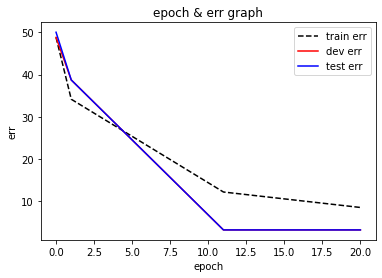

In [53]:
# epoch-err curve
if (to_train):
    plt.plot(x_epoch, y_train_err, color = 'black', label = 'train err', linestyle = '--')
    plt.plot(x_epoch, y_dev_err, color = 'red', label = 'dev err')
    plt.plot(x_epoch, y_test_err, color='blue', label = 'test err')
    
    plt.xlabel('epoch')
    plt.ylabel('err')
    plt.title('epoch & err graph')
    plt.legend(loc="upper right")
    plt.show()

## 6. Evaluation for dev & test data

Normalized confusion matrix


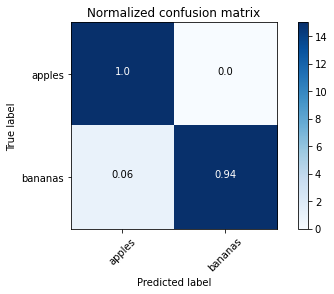

Confusion matrix, without normalization


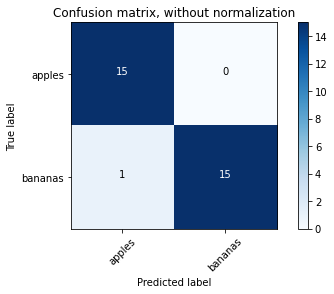

	 acc  |	 pre  |	 rec  |	 f1
 apples: 0.97 |	 0.94 |	 1.00 |	 0.97
 bananas: 0.97 |	 1.00 |	 0.94 |	 0.97
*accuracy: 0.97, precision: 0.97, recall: 0.97, *f1 score: 0.97
[AP]
apples: 0.95
bananas: 0.98

[mAP] 0.962
[miAP] 0.984


(array([1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
        1, 1, 0, 1, 0, 0, 0, 0, 0]),
 array([1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1,
        1, 1, 0, 1, 0, 0, 0, 0, 0]),
 array([0.87844461, 0.74920112, 0.8766048 , 0.85828978, 0.94645327,
        0.57169658, 0.90508342, 0.98321599, 0.97700387, 0.96291023,
        0.92337853, 0.87474024, 0.89567024, 0.8734948 , 0.91405487,
        0.96274984, 0.9544844 , 0.95767486, 0.90768844, 0.89292008,
        0.82866007, 0.89217228, 0.9461965 , 0.92819798, 0.98646462,
        0.98829073, 0.81110126, 0.83955002, 0.84730422, 0.99235213,
        0.84417999]))

In [54]:
model.eval()
utils.EvaluateClassifier(dev_batch, model, dev_data.classes, batch_size)

Category: apples
 True predicted images/total apples category: 15 / 15
Predicted probability:
[0.81110126 0.18889877]


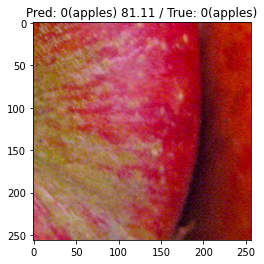

Predicted probability:
[0.7492011  0.25079885]


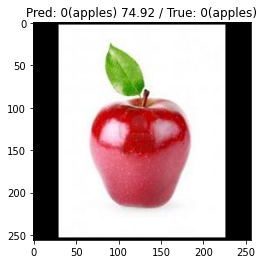

 False predicted images/total apples category: 0 / 15
Category: bananas
 True predicted images/total bananas category: 15 / 16
Predicted probability:
[0.1417102 0.8582898]


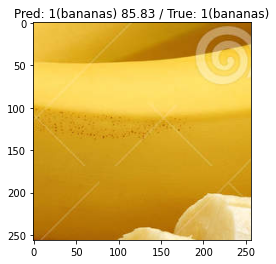

Predicted probability:
[0.08594515 0.9140549 ]


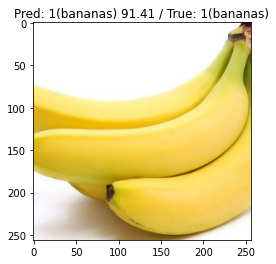

 False predicted images/total bananas category: 1 / 16
Predicted probability:
[0.90768844 0.09231156]


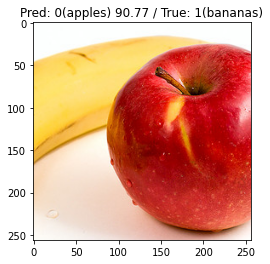

In [55]:
utils.VisTFPred(dev_batch, model,test_data.classes, batch_size, i_n=2)